<a href="https://colab.research.google.com/github/tripuragorla/CMPE-297-Assignments/blob/main/Assignment%203/HuggingFaces_AudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
model_checkpoint = "facebook/wav2vec2-base"
batch_size = 32

In [ ]:
%%capture
!pip install datasets==1.14
!pip install transformers==4.11.3
!pip install librosa

In [ ]:
!pip install wandb
!wandb login

wandb: Currently logged in as: shivkumarganesh (use `wandb login --relogin` to force relogin)


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!apt install git-lfs
!git-lfs

## Fine-tuning a model

### Loading the data

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
dataset = load_dataset("superb", "ks")
metric = load_metric("accuracy")

Reusing dataset superb (/root/.cache/huggingface/datasets/superb/ks/1.9.0/ce836692657f82230c16b3bbcb93eaacdbfd7de4def3be90016f112d68683481)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 3081
    })
})

In [ ]:
dataset["test"][1000]

{'audio': {'array': array([-1.2207031e-04,  3.0517578e-05,  1.8310547e-04, ...,
         -4.8828125e-04, -5.4931641e-04, -3.3569336e-04], dtype=float32),
  'path': '/root/.cache/huggingface/datasets/downloads/extracted/94c69f12cc18539f842ccec832347d0f85a3424c14bc47bd63902105ba1b2391/go/e41a903b_nohash_4.wav',
  'sampling_rate': 16000},
 'file': '/root/.cache/huggingface/datasets/downloads/extracted/94c69f12cc18539f842ccec832347d0f85a3424c14bc47bd63902105ba1b2391/go/e41a903b_nohash_4.wav',
 'label': 9}

In [ ]:
dataset["train"].features["label"]

ClassLabel(num_classes=12, names=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_silence_', '_unknown_'], names_file=None, id=None)

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["9"]

'go'

In [ ]:
dataset["test"][1000]["audio"]

{'array': array([-1.2207031e-04,  3.0517578e-05,  1.8310547e-04, ...,
        -4.8828125e-04, -5.4931641e-04, -3.3569336e-04], dtype=float32),
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/94c69f12cc18539f842ccec832347d0f85a3424c14bc47bd63902105ba1b2391/go/e41a903b_nohash_4.wav',
 'sampling_rate': 16000}

In [ ]:
import random
from IPython.display import Audio, display

for _ in range(5):
    rand_idx = random.randint(0, len(dataset["train"])-1)
    example = dataset["train"][rand_idx]
    audio = example["audio"]

    print(f'Label: {id2label[str(example["label"])]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Label: _unknown_
Shape: (16000,), sampling rate: 16000



Label: no
Shape: (16000,), sampling rate: 16000



Label: _unknown_
Shape: (14336,), sampling rate: 16000



Label: off
Shape: (16000,), sampling rate: 16000



Label: on
Shape: (16000,), sampling rate: 16000


### Preprocessing

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
max_duration = 1.0  # seconds

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length=int(feature_extractor.sampling_rate * max_duration), 
        truncation=True, 
    )
    return inputs

In [ ]:
preprocess_function(dataset['train'][:5])

{'input_values': [array([-9.1631009e-05, -9.1631009e-05, -9.1631009e-05, ...,
       -4.6719767e-02, -8.0353022e-01, -1.3182331e+00], dtype=float32), array([0.01049979, 0.01049979, 0.01049979, ..., 0.6454253 , 0.43378347,
       0.25741526], dtype=float32), array([ 9.0340059e-04,  9.0340059e-04,  9.0340059e-04, ...,
       -1.7281245e-01,  2.2313449e-01,  1.9931581e+00], dtype=float32), array([ 1.5586768 ,  0.3870289 ,  0.74101615, ..., -0.8897349 ,
       -0.7703889 , -0.09471782], dtype=float32), array([-0.01518929, -0.01518929, -0.01518929, ..., -0.84138   ,
        0.22227868, -0.02409434], dtype=float32)]}

In [ ]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio", "file"], batched=True)
encoded_dataset

Loading cached processed dataset at /root/.cache/huggingface/datasets/superb/ks/1.9.0/ce836692657f82230c16b3bbcb93eaacdbfd7de4def3be90016f112d68683481/cache-85174773a4d61317.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/superb/ks/1.9.0/ce836692657f82230c16b3bbcb93eaacdbfd7de4def3be90016f112d68683481/cache-6b34ba9a20795a13.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/superb/ks/1.9.0/ce836692657f82230c16b3bbcb93eaacdbfd7de4def3be90016f112d68683481/cache-2b129ced6cb1bee2.arrow


DatasetDict({
    train: Dataset({
        features: ['input_values', 'label'],
        num_rows: 51094
    })
    validation: Dataset({
        features: ['input_values', 'label'],
        num_rows: 6798
    })
    test: Dataset({
        features: ['input_values', 'label'],
        num_rows: 3081
    })
})

### Training the model

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)


/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.weight', 'project_q.bias', 'quantizer.codevectors', 'project_hid.bias', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertFor

In [ ]:
import wandb
wandb.init(project="Hugging Face Audio-Classification-on-Keyword-Spotting", entity="shivkumarganesh")

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetune-wav2vec",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to='wandb'
)

PyTorch: setting up devices


In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        
Username: gshiv.sk@gmail.com
Password: 
Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
!git config --global credential.helper store
!repo.git_pull()

/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/shivkumarganesh/wav2vec2-base-finetune-wav2vec into local empty directory.


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 51094
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 399
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
0,1.259200,1.297504,0.645337


***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32
Saving model checkpoint to wav2vec2-base-finetune-wav2vec/checkpoint-399
Configuration saved in wav2vec2-base-finetune-wav2vec/checkpoint-399/config.json
Model weights saved in wav2vec2-base-finetune-wav2vec/checkpoint-399/pytorch_model.bin
Configuration saved in wav2vec2-base-finetune-wav2vec/checkpoint-399/preprocessor_config.json
Configuration saved in wav2vec2-base-finetune-wav2vec/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from wav2vec2-base-finetune-wav2vec/checkpoint-399 (score: 0.6453368637834658).


TrainOutput(global_step=399, training_loss=1.5166920492224825, metrics={'train_runtime': 927.6472, 'train_samples_per_second': 55.079, 'train_steps_per_second': 0.43, 'total_flos': 4.6367652667392e+17, 'train_loss': 1.5166920492224825, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 6798
  Batch size = 32


{'epoch': 1.0,
 'eval_accuracy': 0.6453368637834658,
 'eval_loss': 1.2975035905838013,
 'eval_runtime': 80.7143,
 'eval_samples_per_second': 84.223,
 'eval_steps_per_second': 2.639}

In [ ]:
wandb.finish()

eval/accuracy,▁▁
eval/loss,▁▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/learning_rate,▃▄▆███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▇▆▄▃▃▃▂▂▂▃▃▂▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁
train/total_flos,▁
train/train_loss,▁


#Wandb Train
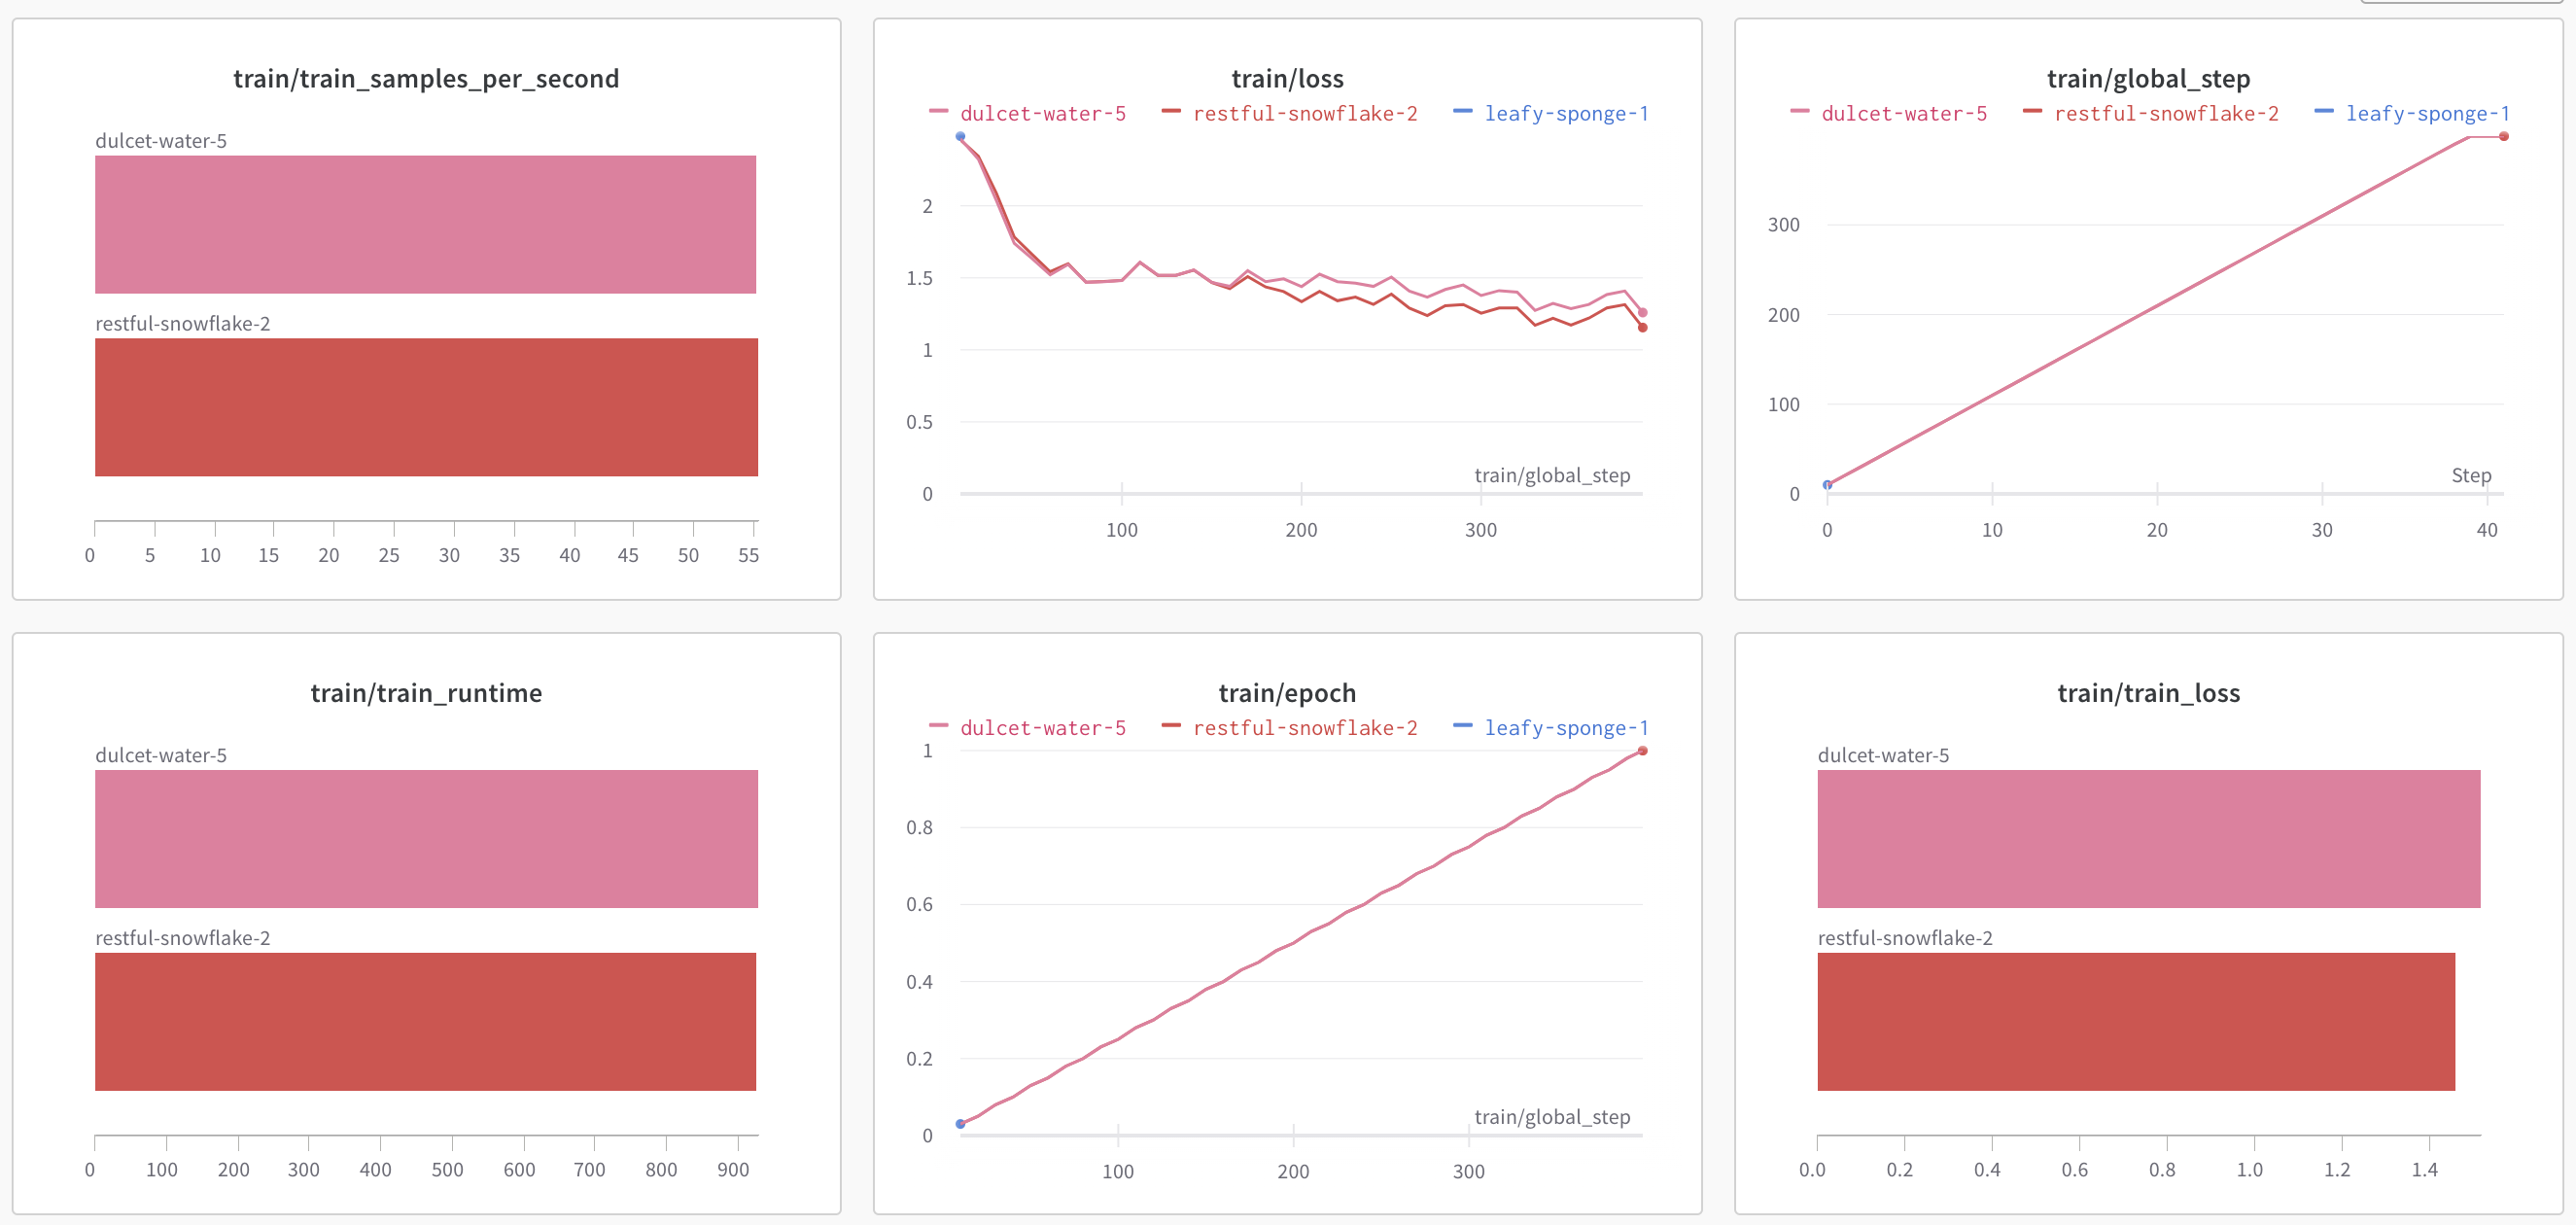

#Wandb Eval
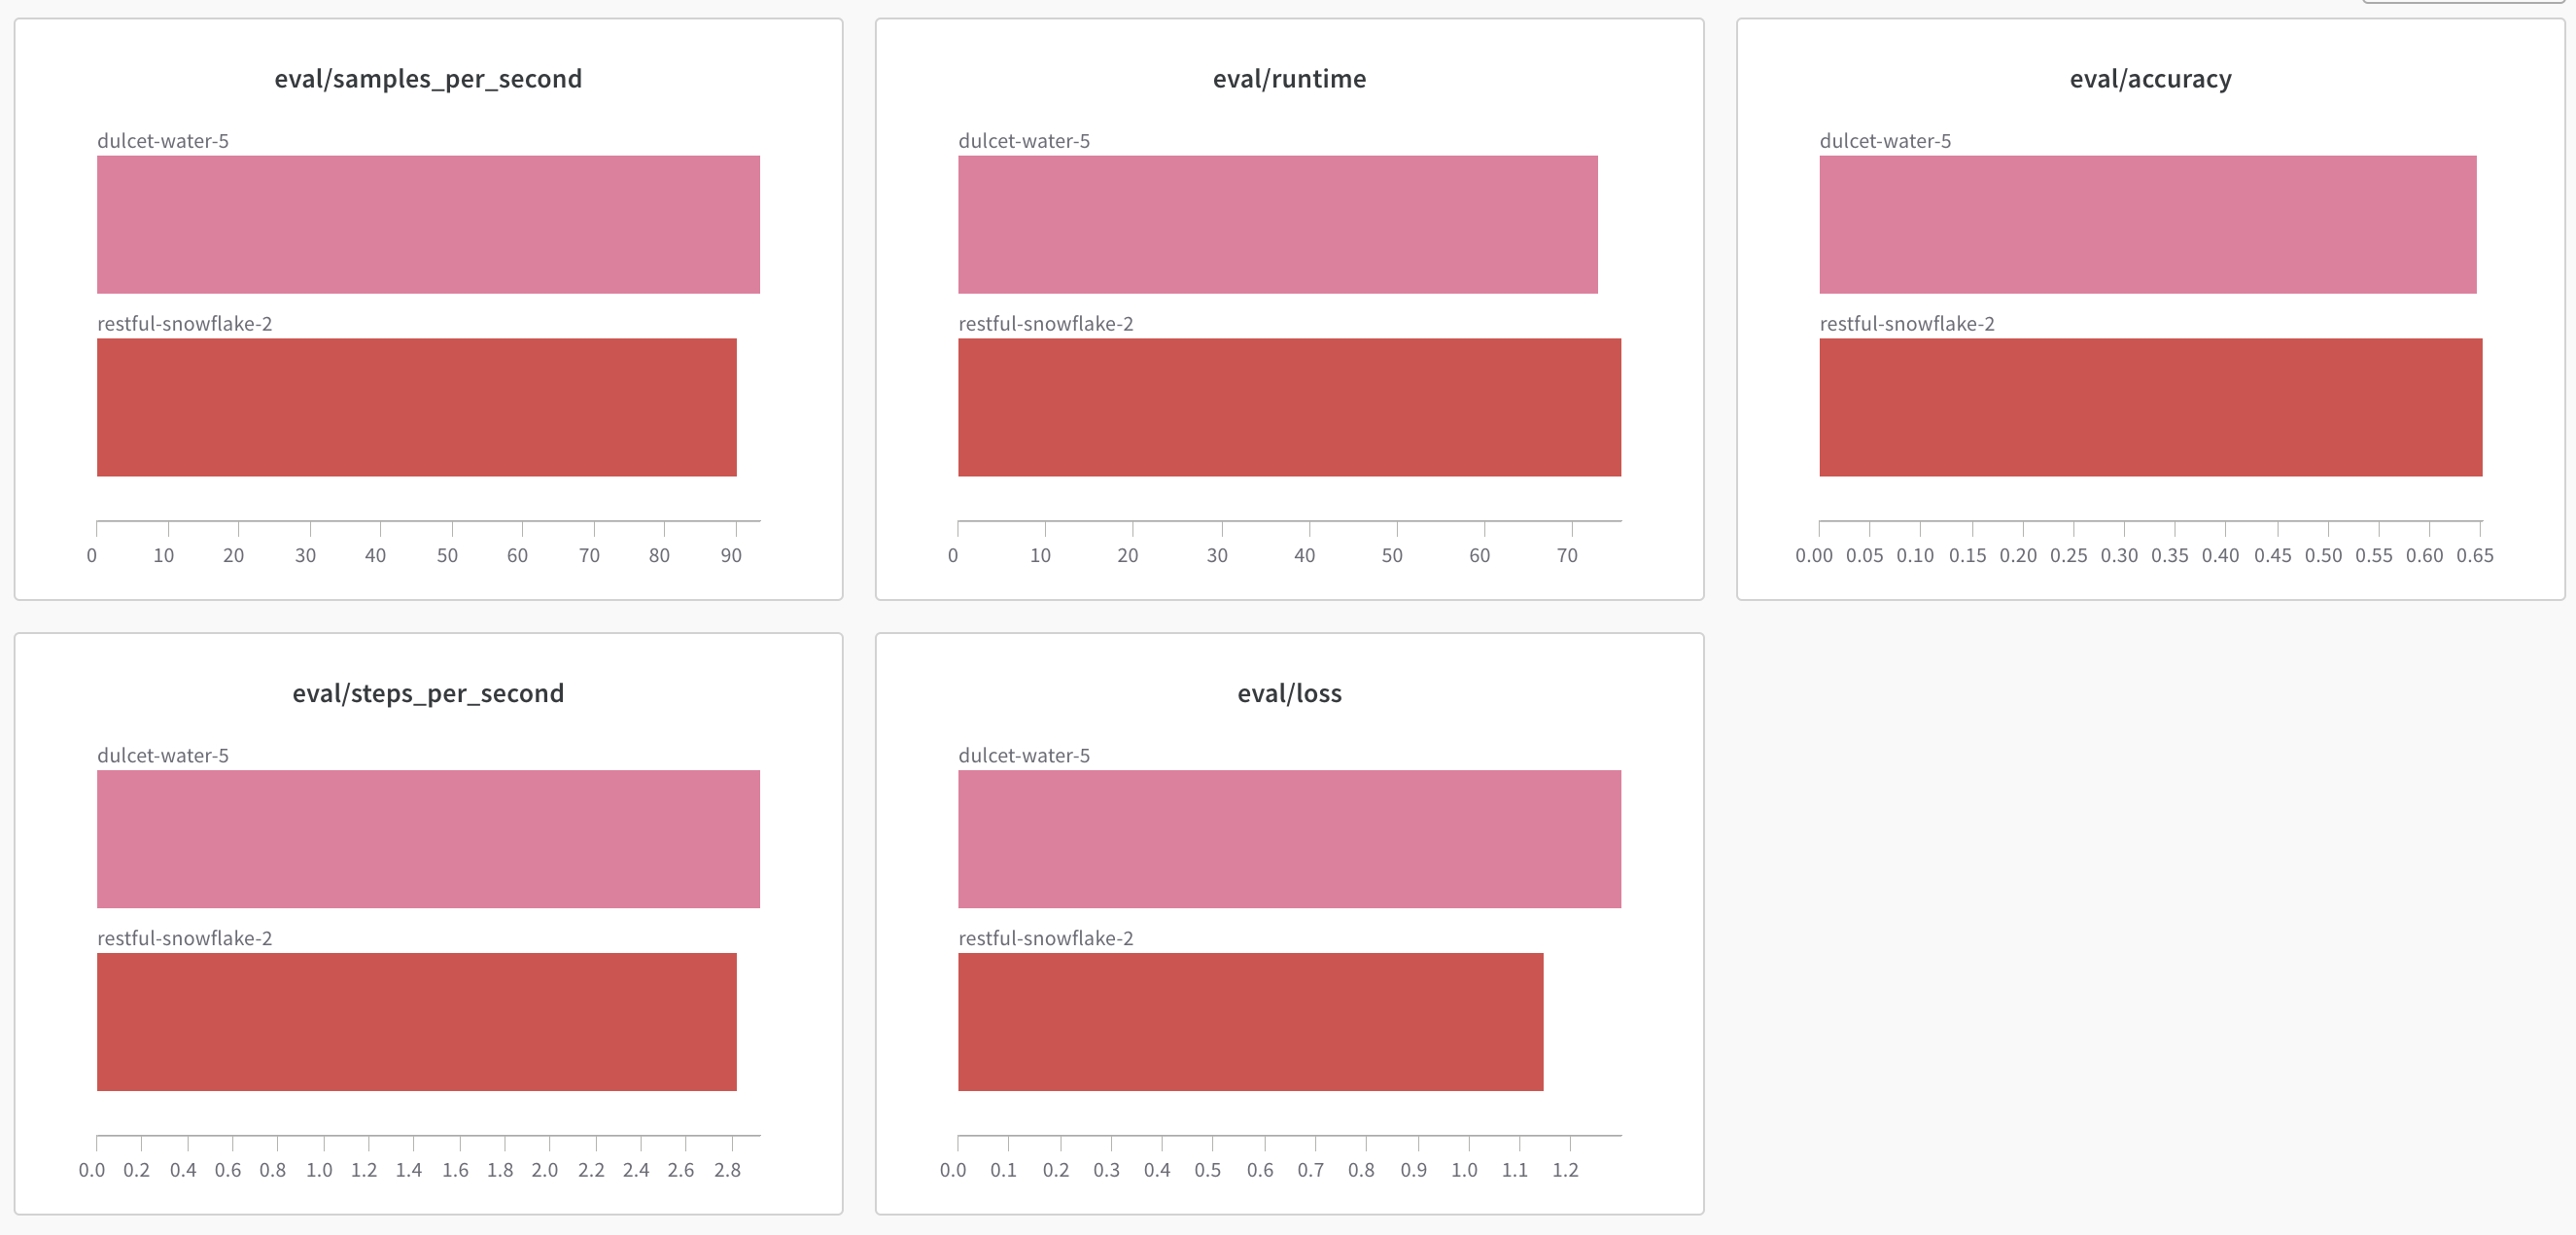

In [ ]:
https://huggingface.co/transformers/notebooks.html